In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from sunpy.time import TimeRange
import matplotlib.dates as mdates
import datetime as dt
import scipy
from scipy.signal import firwin, freqz, lfilter

%matplotlib notebook

/home/ofionnad/realta/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
fname = 'udpoutput/cygA-1s-stokesI-notimedec_0_2020-10-13T17:47:00_ld'
sbs = np.arange(76, 197)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 1.*u.second)
"""
fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 319)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.minute)
"""

xlabel = "Time"
ylabel = "Frequency (MHz)"
title = "Cyg A - Stokes I"

In [3]:
def sb_to_f(sbs, obs_mode):
    nyq_dict = {3:1, 5:2, 7:3}
    nyq_zone = nyq_dict[obs_mode]
    clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
    clock = clock_dict[obs_mode]
    nu = (nyq_zone-1. + sbs/512.) * (clock/2.)
    return nu * u.MHz

In [4]:
def bg(data, amount=0.05):
        #tmp = data - np.mean(data, axis=0) 
        sdevs = np.mean(data, 1)
        cand = sorted(range(data.shape[0]), key=lambda y: sdevs[y])
        realcand = cand[:max(1, int(amount*len(cand)))]
        bg = np.mean(data[realcand, :], 0)
        return bg

In [5]:
#df = np.fromfile(fname, dtype=np.float32)
df = np.memmap(fname, np.float32, mode="c")

In [6]:
len(sbs)

121

In [7]:
freqs = sb_to_f(sbs, obs_mode)

In [8]:
print(min(freqs).value, max(freqs))

14.84375 38.28125 MHz


In [9]:
df = df.reshape(-1, sbs.shape[0]+1)
df = np.flip(df, axis=1)

In [10]:
df.shape

(195312, 122)

In [11]:
sdf = df[:,:]

In [12]:
sdf.shape
#sdf = sdf[:,40:80]

(195312, 122)

In [13]:
#sfd = sdf/ bg(sdf)

In [40]:
subbands = [78]
a = sdf[:,subbands]
print("{}".format(sb_to_f(subbands[0]+sbs[0], obs_mode)))#, sb_to_f(subbands[1]+sbs[0], obs_mode)))

30.078125 MHz


In [112]:
#a = a.T
a = sdf.T

In [113]:
a.shape

(122, 195312)

In [114]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

<IPython.core.display.Javascript object>


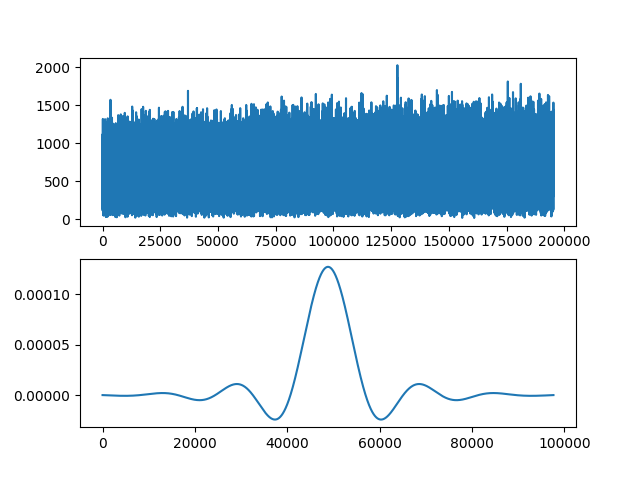

In [115]:
M, P = 12, 8138 #multiple must factor into length of time series data.



win_coeffs = generate_win_coeffs(M, P, window_fn="hamming")

fig, ax = plt.subplots(2)
ax[0].plot(a[0])
ax[1].plot(win_coeffs)

In [116]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = x.shape[0] // M // P
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M + 1))
    for t in range(0, M*W-M + 1):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [117]:
y_p = pfb_fir_frontend(a[0], win_coeffs, M, P)

In [118]:
y_p.shape

(13, 8138)

In [119]:
print("n_taps: %i" % M)
print("n_branches: %i" % P)
print("Input signal shape: {}".format(a.shape))
print("Window shape:       {}".format(win_coeffs.shape))
print("Output data shape: {}".format(str(y_p.shape)))

n_taps: 12
n_branches: 8138
Input signal shape: (122, 195312)
Window shape:       (97656,)
Output data shape: (13, 8138)


<IPython.core.display.Javascript object>


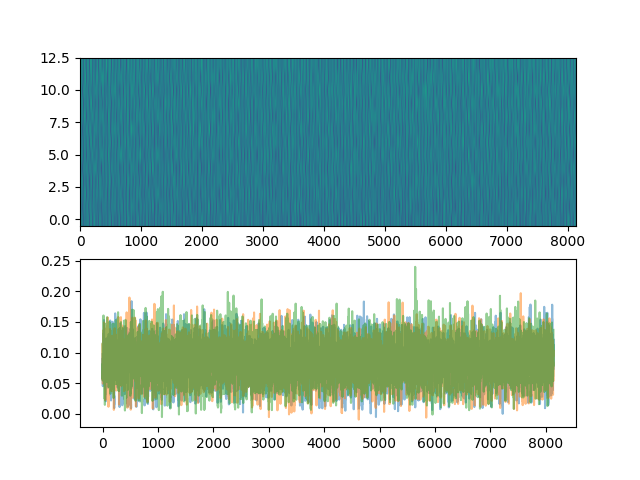

In [120]:
### quick look at our polyphase de
f, ax = plt.subplots(2)
ax[0].imshow(y_p, aspect='auto', origin='lower')
ax[1].plot(y_p[0], alpha=0.5)
ax[1].plot(y_p[2], alpha=0.5)
ax[1].plot(y_p[10], alpha=0.5)

In [121]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

In [122]:
def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

In [194]:
a[0].shape[0] / 16

12207.0

In [302]:
M     = 12          # Number of taps
P     = 8138        # Number of 'branches', also fft length
n_int = 4          # Number of time integrations on output data

a_out = pfb_spectrometer(a[120], M, P, n_int, window_fn="hamming")

In [303]:
a_out.shape

(3, 4070)

<IPython.core.display.Javascript object>


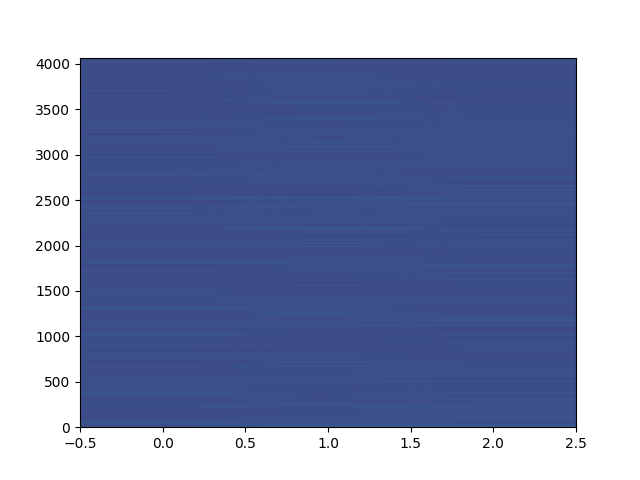

In [304]:
f, ax = plt.subplots()
ax.imshow(db(a_out.T), aspect='auto', origin='lower')
#plt.colorbar()
#plt.plot(a_out.T)

In [93]:
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)